In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from scipy import signal
from scipy.io import wavfile
from scipy.stats import pearsonr, zscore
from mne_bids import BIDSPath
from functools import partial
from nilearn.plotting import plot_markers
import torch
import torchaudio
from transformers import WhisperProcessor, WhisperModel, AutoFeatureExtractor, AutoProcessor, WhisperForConditionalGeneration, WhisperTokenizer
from utils import preprocess_raw_audio, get_stimuli_and_brain, set_seed, contrastive_loss
from models import AttentiveStim2BrainNet, PositionalEncoding, LearnableTau, SoftMappingGRUSeq
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import os
import h5py

/home/matteoc/miniconda3/envs/huggin/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "openai/whisper-base"

model_w = WhisperModel.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
tokenizer_w = WhisperTokenizer.from_pretrained(model_name)
processor_w = AutoProcessor.from_pretrained(model_name)
model_w.eval()

WhisperModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    

In [3]:
df_word = pd.read_csv("/srv/nfs-data/sisko/matteoc/podcast/df_word.csv")

In [4]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
base_path = "/srv/nfs-data/sisko"
bids_root = base_path + "/storage/ECoG_podcast/ds005574-1.0.2"

func = partial(zscore)    # axis=1
ecog_sr = 512
ecog_sr_down = 32
whisper_sr = 16000
tmax = 2.0
pre_stimulus = 2.0
pre_audio = 0.2
subject = "03"

audio_path = f"{bids_root}/stimuli/podcast.wav"
audio_sf, audio_wave = wavfile.read(audio_path)
audio_wave_clean = preprocess_raw_audio(audio_wave, audio_sf)

file_path = BIDSPath(root=bids_root+"/derivatives/ecogprep",
                     subject=subject,
                     task="podcast",
                     datatype="ieeg",
                     suffix="ieeg",
                     extension="fif")

# transcript_path = f"{bids_root}/stimuli/podcast_transcript.csv"
# df = pd.read_csv(transcript_path)
# df.dropna(subset=['start'], inplace=True)
# df.sort_values("start", inplace=True)
# events = np.zeros((len(df), 3))
# events[:, 0] = df.start


/tmp/ipykernel_1939545/2251066288.py:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  audio_sf, audio_wave = wavfile.read(audio_path)


In [5]:
downl_flag = False

def get_stimuli_and_brain(file_path, audio_wave_clean, audio_sf, df, 
                          tmax=2.0, pre_stimulus=2.0,
                          model=None, processor=None, whisper_sr=16000,
                          device=device):

    model = model.to(device)
    
    raw = mne.io.read_raw_fif(file_path, verbose=False)
    raw.load_data()
    raw = raw.apply_function(func, channel_wise=True, verbose=False)

    events = np.zeros((len(df), 3), dtype=int)
    events[:, 0] = (df.start * raw.info['sfreq']).astype(int)

    epochs = mne.Epochs(
        raw,
        events,
        tmin=-pre_stimulus,
        tmax=tmax,
        baseline=None,
        proj=False,
        event_id=None,
        preload=True,
        event_repeated="merge",
        verbose=False
    )
    good_idx = epochs.selection
    print(f"Epochs object has a shape of: {epochs._data.shape}")
    epochs = epochs.resample(sfreq=ecog_sr_down, npad='auto', method='fft', window='hamming')
    epochs_snippet = epochs._data
    print(f"Epochs object after down-sampling has a shape of: {epochs_snippet.shape}")

    audio_snip_whisper = []

    if downl_flag:
        for idx in tqdm.tqdm(range(len(good_idx))):
            row = df.iloc[idx]

            # Estrai esattamente l'intervallo audio della parola
            start_sample = int(row['start'] * audio_sf)
            end_sample = int(row['end'] * audio_sf)
            snippet = audio_wave_clean[start_sample:end_sample]

            # Resample e prepara input per Whisper
            snippet = torch.tensor(snippet).float()
            snippet = torchaudio.transforms.Resample(orig_freq=audio_sf, new_freq=whisper_sr)(snippet)
            inputs = processor(snippet, sampling_rate=whisper_sr, return_tensors="pt")
            input_features = inputs['input_features'].to(device)

            with torch.no_grad():
                outputs = model.encoder(input_features=input_features, output_hidden_states=False)
                hidden = outputs.last_hidden_state.squeeze(0)  # (seq_len, 512)

            # Corrispondenza temporale audio ↔ whisper
            whisper_tokens_per_sec = 50  # Whisper frame rate
            tot_frame = int(row['end'] * whisper_tokens_per_sec) - int(row['start'] * whisper_tokens_per_sec)
            hidden_segment = hidden[:tot_frame]
            hidden_segment = hidden_segment.mean(dim=0)

            audio_snip_whisper.append(hidden_segment.cpu())

        audio_snip_whisper = torch.stack(audio_snip_whisper, dim=0)  

    else:
        audio_snip_whisper = torch.load("/srv/nfs-data/sisko/matteoc/podcast/audio_embeds_whis.pt")

    print(f"Audio snippets after processing have a shape of: {audio_snip_whisper.shape}")

    return epochs_snippet, audio_snip_whisper, good_idx


In [6]:
brain_data, audio_data, good_idx = get_stimuli_and_brain(file_path, audio_wave_clean, audio_sf, df=df_word, 
                                                    tmax=tmax, model=model_w,
                                                    processor=processor_w, pre_stimulus=pre_stimulus)

text_data_last = torch.load("/srv/nfs-data/sisko/matteoc/podcast/text_embeds_gpt.pt")
text_data_eleven = torch.load("/srv/nfs-data/sisko/matteoc/podcast/text_embeds_gpt_eleven.pt")
text_data_last = text_data_last[good_idx]
text_data_eleven = text_data_eleven[good_idx]

Reading 0 ... 921599  =      0.000 ...  1799.998 secs...


/tmp/ipykernel_1939545/4284289440.py:17: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


Epochs object has a shape of: (5130, 235, 2049)
Epochs object after down-sampling has a shape of: (5130, 235, 128)
Audio snippets after processing have a shape of: torch.Size([5130, 512])


/tmp/ipykernel_1939545/4284289440.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  audio_snip_whisper = torch.load("/srv/nfs-data/sisko/matteoc/podcast/audio_embeds_whis

In [7]:
# embedding_path = f"{bids_root}/stimuli/gpt2-xl/features.hdf5"
# modelname, layer = 'gpt2-xl', 24
# with h5py.File(embedding_path, "r") as f:
#     contextual_embeddings = f[f"layer-{layer}"][...]
# print(f"LLM embedding matrix has shape: {contextual_embeddings.shape}")

# transcript_path = f"{bids_root}/stimuli/gpt2-xl/transcript.tsv"
# df_contextual = pd.read_csv(transcript_path, sep="\t", index_col=0)
# if "rank" in df_contextual.columns:
#     model_acc = (df_contextual["rank"] == 0).mean()
#     print(f"Model accuracy: {model_acc*100:.3f}%")

# aligned_embeddings = []
# for _, group in df_contextual.groupby("word_idx"): # group by word index
#     indices = group.index.to_numpy()
#     average_emb = contextual_embeddings[indices].mean(0)
#     aligned_embeddings.append(average_emb)
# aligned_embeddings = np.stack(aligned_embeddings)
# print(f"LLM embeddings matrix has shape: {aligned_embeddings.shape}")

# aligned_embeddings = aligned_embeddings[good_idx]



In [7]:
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

epochs_data = brain_data.reshape(len(brain_data), -1)

X = text_data_last
Y = epochs_data

if "torch" in get_backend().__name__:
    X = X.astype(np.float32)
    Y = Y.astype(np.float32)

X.shape, Y.shape

(torch.Size([5130, 768]), (5130, 30080))

In [8]:
alphas = np.logspace(1, 10, 10) # specify alpha values
inner_cv = KFold(n_splits=5, shuffle=False) # inner 5-fold cross-validation setup
model = make_pipeline(
    StandardScaler(), RidgeCV(alphas, fit_intercept=True, cv=inner_cv) # pipeline
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10]),
                         cv=KFold(n_splits=5, random_state=None, shuffle=False),
                         fit_intercept=True))])

In [9]:
epochs_shape = brain_data.shape[1:] # number of electrodes * number of lags

def train_encoding(X, Y):

    all_corrs = [] # empty array to store correlation results
    kfold = KFold(2, shuffle=False) # outer 2-fold cross-validation setup
    for train_index, test_index in kfold.split(X): # loop through folds

        # Split train and test datasets
        X1_train, X1_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Standardize Y
        scaler = StandardScaler()
        Y_train = scaler.fit_transform(Y_train)
        Y_test = scaler.transform(Y_test)

        model.fit(X1_train, Y_train) # Fit pipeline with transforms and ridge estimator
        Y_preds = model.predict(X1_test) # Predict on test set and reshape to epochs shape
        Y_preds = Y_preds.reshape(-1, epochs_shape[0], epochs_shape[1])

        corrs = np.zeros((epochs_shape[0], epochs_shape[1]))
        for ch in tqdm.tqdm(range(epochs_shape[0])):
            for t in range(epochs_shape[1]):
                corr, _ = pearsonr(Y_preds[:, ch, t], Y_test.reshape(-1, epochs_shape[0], epochs_shape[1])[:, ch, t])
                corrs[ch, t] = corr
        all_corrs.append(corrs)
        
        # corr = correlation_score(Y_test, Y_preds).reshape(epochs_shape) # Compute correlation score
        # if "torch" in get_backend().__name__: # if using gpu, transform tensor back to numpy
        #     corr = corr.numpy(force=True)
        # all_corrs.append(corr) # append fold correlation results to final results

    return np.stack(all_corrs), Y_preds, Y_test

# set_backend("torch") # resort to torch or numpy if cuda out of memory
corrs_embedding, Y_preds, Y_test = train_encoding(X, Y)
print(f"Encoding performance correlating matrix shape: {corrs_embedding.shape}")

100%|██████████| 235/235 [00:16<00:00, 14.66it/s]

Encoding performance correlating matrix shape: (2, 235, 128)


In [10]:
# base_mod = 'baseline'
# to_save_path = f"{base_path}/matteoc/podcast/subj_data/sub_{subject}_soft"
# os.makedirs(to_save_path, exist_ok=True)
# np.save(f"{to_save_path}/pval_layer_{base_mod}.npy", pvals_embd)
# np.save(f"{to_save_path}/corr_layer_{base_mod}.npy", corrs_embedding)

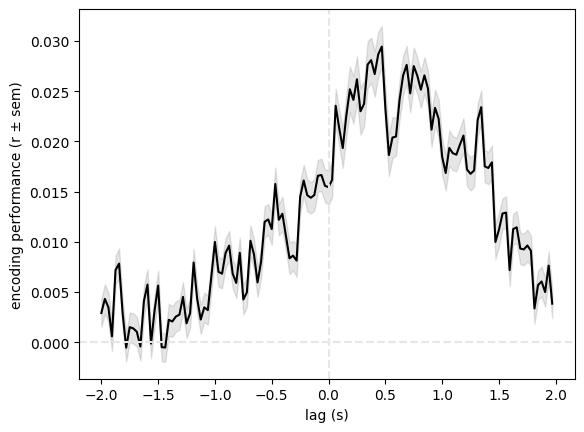

In [11]:
lags = np.arange(-2 * 512, 2 * 512, 16) / 512 # specify the lags
mean = corrs_embedding.mean((0,1))
err = corrs_embedding.std((0,1)) / np.sqrt(np.product(corrs_embedding.shape[:2]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - err, mean + err, alpha=0.1, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r ± sem)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

Coordinate matrix shape:  (235, 3)


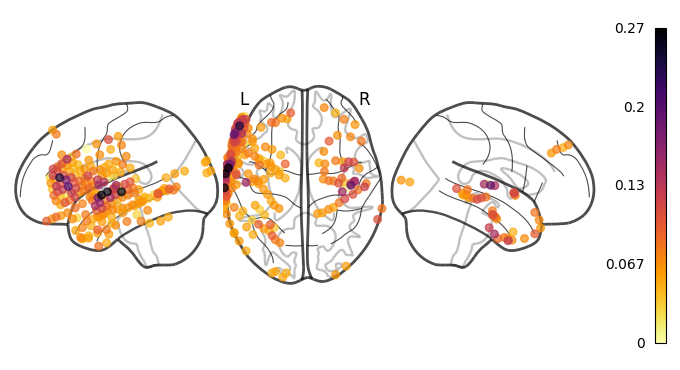

In [12]:
values = corrs_embedding.mean(0).max(-1)
raw = mne.io.read_raw_fif(file_path, verbose=False)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = values.argsort()
plot_markers(values[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()

In [136]:
Y_preds = Y_preds.reshape(-1, epochs_shape[0], epochs_shape[1])[0:1024]
Y_test = Y_test.reshape(-1, epochs_shape[0], epochs_shape[1])[0:1024]

In [137]:
Y_preds.shape

(1024, 188, 128)

In [138]:
def batch_pearson_corr(x, y):
    """ x, y: tensors of shape (n_samples, n_features) """
    x_centered = x - x.mean(dim=1, keepdim=True)
    y_centered = y - y.mean(dim=1, keepdim=True)
    numerator = (x_centered * y_centered).sum(dim=1)
    denominator = torch.sqrt((x_centered**2).sum(dim=1) * (y_centered**2).sum(dim=1))
    return numerator / (denominator + 1e-8)  # aggiunta eps per stabilità numerica


n_permutations = 500
n_samples, n_channels, n_timepoints = Y_preds.shape

null_distribution_tp = np.zeros((n_permutations, n_timepoints))
null_distribution_ch = np.zeros((n_permutations, n_channels))

for perm in tqdm.tqdm(range(n_permutations), desc="Permutation runs"):
    shuffled_idx = np.random.permutation(n_samples)
    y_true_perm = Y_test[shuffled_idx]

    for tp in range(n_timepoints):
        pred_tp = torch.tensor(Y_preds[:, :, tp]).to(device)  # (samples, voxels)
        true_tp = torch.tensor(y_true_perm[:, :, tp]).to(device)  
        corrs = batch_pearson_corr(pred_tp, true_tp)  # (samples,)
        null_distribution_tp[perm, tp] = corrs.mean().item()

    for ch in range(n_channels):
        pred_ch = torch.tensor(Y_preds[:, ch, :]).to(device)  
        true_ch = torch.tensor(y_true_perm[:, ch, :]).to(device)  
        corrs_ch = batch_pearson_corr(pred_ch, true_ch)  
        null_distribution_ch[perm, ch] = corrs_ch.mean().item()

Permutation runs: 100%|██████████| 500/500 [02:29<00:00,  3.34it/s]


In [139]:
real_corr_tp = corrs_embedding.mean((0,1))
real_corr_ch = corrs_embedding.mean((0,2))
p_values_tp = np.mean(null_distribution_tp >= real_corr_tp[None, :], axis=0)  
p_values_ch = np.mean(null_distribution_ch >= real_corr_ch[None, :], axis=0)  

In [140]:
from statsmodels.stats.multitest import fdrcorrection

significant_tp, pvals_corrected_tp = fdrcorrection(p_values_tp, alpha=0.05)
significant_ch, pvals_corrected_ch = fdrcorrection(p_values_ch, alpha=0.05)

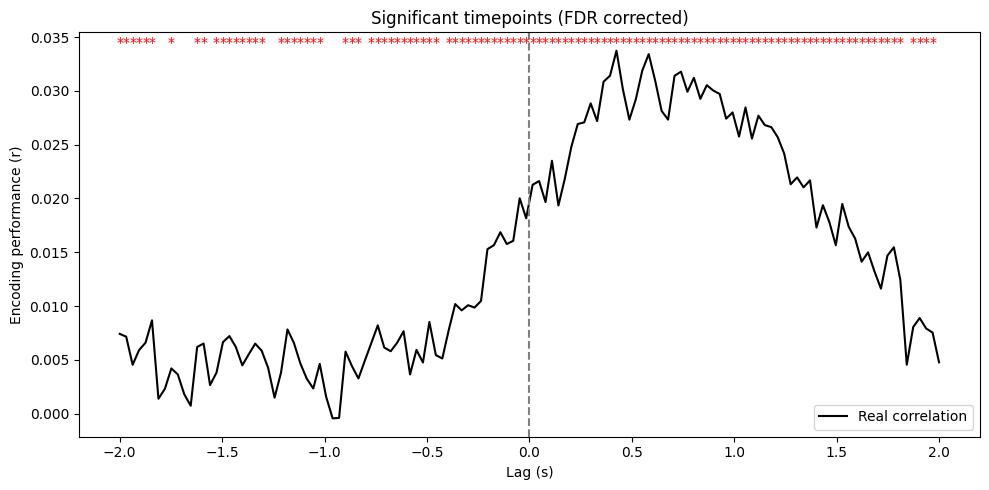

In [141]:
import matplotlib.pyplot as plt

lags = np.linspace(-2.0, 2.0, corrs_embedding.shape[-1])  # Assicurati sia coerente

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(lags, real_corr_tp, color='black', label='Real correlation')
ax.axvline(0, color='gray', linestyle='--')
y_top = real_corr_tp.max() + 0.0001
# Aggiungi asterischi nei timepoint significativi
for t, sig in enumerate(significant_tp):
    if sig:
        ax.text(lags[t], y_top, '*', color='red', fontsize=10,
                ha='center', va='bottom')

ax.set_xlabel('Lag (s)')
ax.set_ylabel('Encoding performance (r)')
ax.set_title('Significant timepoints (FDR corrected)')
ax.legend()
plt.tight_layout()
plt.show()


In [142]:
tosave_stats = f"/srv/nfs-data/sisko/matteoc/podcast/subj_data/sub_{subject}_baseline"
os.makedirs(tosave_stats, exist_ok=True)
np.save(os.path.join(tosave_stats, "significant_tp_text.npy"), significant_tp)
np.save(os.path.join(tosave_stats, "significant_ch_text.npy"), significant_ch)
np.save(os.path.join(tosave_stats, "correlations_text.npy"), corrs_embedding)


## Load Saved Results

In [5]:
import os
import numpy as np
from joblib import Parallel, delayed
import tqdm

base_path = "/srv/nfs-data/sisko"
subjects = ['01', '02', '03', '04', '05', '06', '07', '08', '09'] 
subj_data_base_path = f"{base_path}/matteoc/podcast/subj_data"

def load_subject_data(subject):
    subj_dir = f"{subj_data_base_path}/sub_{subject}_baseline"    
    sign_ch = None
    sign_tp = None

    sign_ch_file = f"{subj_dir}/significant_ch_text.npy"
    corrs_file = f"{subj_dir}/correlations_text.npy"

    coords = None
    coords_file = f"{subj_dir}/coords_ch.npy"
    if os.path.exists(coords_file):
        coords = np.load(coords_file)

    if os.path.exists(sign_ch_file) and os.path.exists(corrs_file):
        sign_ch = np.load(sign_ch_file)  # shape: (n_channels,)
        sign_tp = np.load(f"{subj_dir}/significant_tp_text.npy")  # shape: (n_timepoints,)
        corrs = np.load(corrs_file).mean(axis=0)  # shape: (n_channels, n_timepoints)
        return corrs, sign_ch, sign_tp, coords
    else:
        return None  #  (None, None, None)

results = Parallel(n_jobs=4)(
    delayed(load_subject_data)(subject) for subject in tqdm.tqdm(subjects)
)

results = [r for r in results if r is not None]
corrs_list, sign_ch_list, sign_tp_list, coords_list = zip(*results)  

# Stacka i mask significativi
coords_list = np.concatenate(coords_list, axis=0)
print("Shape of coords_list:", coords_list.shape)
correlations_stack = np.concatenate(corrs_list, axis=0)
print("Shape of correlations stack:", correlations_stack.shape)
sign_ch_stack = np.concatenate(sign_ch_list, axis=0) 
print("Shape of sign_ch_stack:", sign_ch_stack.shape)
sign_tp_stack = np.stack(sign_tp_list, axis=0)  
# Determina i canali/timepoint significativi presenti in almeno metà dei soggetti
common_sign_tp = np.mean(sign_tp_stack, axis=0) >= 0.50
print("Shape of sign_tp_stack:", common_sign_tp.shape)



100%|██████████| 9/9 [00:00<00:00, 16.63it/s]


Shape of coords_list: (1268, 3)
Shape of correlations stack: (1268, 128)
Shape of sign_ch_stack: (1268,)
Shape of sign_tp_stack: (128,)


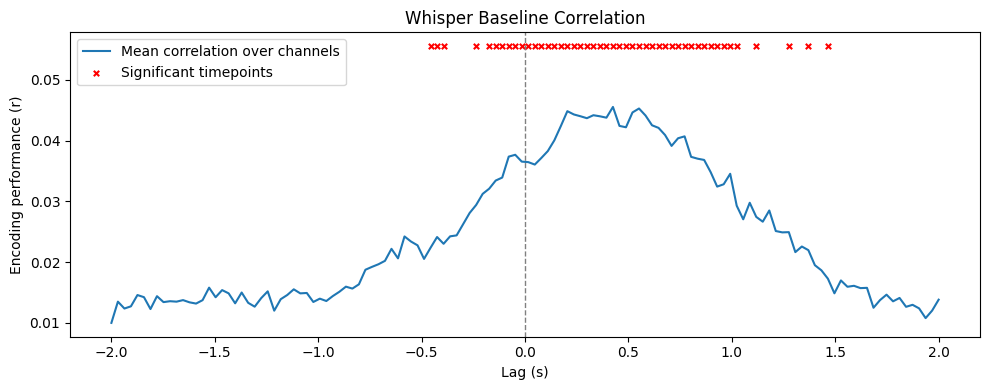

In [6]:
import matplotlib.pyplot as plt

sign_ch_indices = np.where(sign_ch_stack)[0]
sig_tp_indices = np.where(common_sign_tp)[0]
mean_corr_time = correlations_stack[sign_ch_indices].mean(axis=0)
timepoints = np.linspace(-2.0, 2.0, mean_corr_time.shape[0])

sig_tp_times = timepoints[sig_tp_indices]

plt.figure(figsize=(10, 4))
plt.plot(timepoints, mean_corr_time, label='Mean correlation over channels')
plt.xlabel('Lag (s)')
plt.ylabel('Encoding performance (r)')
plt.title('Whisper Baseline Correlation')

y_max = mean_corr_time.max()
plt.scatter(sig_tp_times, [y_max + 0.01] * len(sig_tp_times), color='red', marker='x', s=15, label='Significant timepoints')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)

plt.legend()
plt.tight_layout()
plt.show()


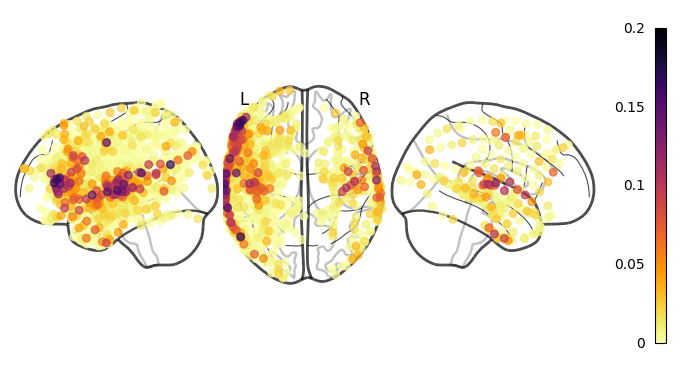

In [10]:
channels_mean = correlations_stack[:,sig_tp_indices].mean(axis=1)
order = channels_mean.argsort()
plot_markers(channels_mean[order], coords_list[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True, node_vmax=0.20)
plt.show()